### Topic: Correlation between Economics and Real Estate


<ul>
<li>College: Mt San Antonio College</li>
<li>Course: CISD41 Introduction to Data Science</li>
<li>by: Alec Phong and Jack Chen</li>
<br>
<br>


### Overview


<ol>
<li>Purpose & Questions</li>
<li>Importing Data</li>
<ul><li>Importing Libraries, Loading Data, Reading Data</li></ul>
<ul><li>Functions, Lambda, and Cleaning</li></ul>
<ul><li>Organizing Sub-Datasets</li></ul>
<ul><li>Merge Sub-Datasets and create House_df</li></ul>
<li>Data Visualization</li>
<ul><li>Pivot Tables and Groupby Table</li></ul>
<ul><li>Additional Cleaning and Organizing to create State_df</li></ul>
<ul><li>House_df</li></ul>
<ul><ul><li>Quantitative Data Exploratory(Correlation, Coefficients, P-values)</li></ul></ul>
<ul><ul><li>Visualization</li></ul></ul>
<ul><li>State_df</li></ul>
<ul><ul><li>Quantitative Data Exploratory(Correlation, Coefficients, P-values)</li></ul></ul>
<ul><ul><li>Visualization</li></ul></ul>

<li>Testing Hypothesis, ANOVA</li>
<ul><li>Chisquare, ANOVA, Normal-test, Z-test, Pearson Correlation</li></ul>
<li>Summary and Conclusion</li>
<li>References</li>
</ol>

### Purpose & Questions

### Cleaning Data

#### Importing Libraries, Loading Data, Reading Data

In [1]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
import scipy.stats as st
%matplotlib inline

# filter warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

init_notebook_mode(connected=True)

In [2]:
# Loading Data
df = pd.read_csv('data/data_house.csv')                     # our main data for housing

spending_df = pd.read_csv('data/data_spending.csv')         # need 1 column of spending per state
gdp_df = pd.read_csv('data/data_gdp.csv')                   # need 1 column of gdp per state
population_df = pd.read_csv('data/data_population.csv')     # need 1 column of population per state
income_df = pd.read_csv('data/data_income.csv')             # need 1 column of income per state


In [3]:
df.shape

(85509, 8)

In [4]:
# Reading the housing data
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85509 entries, 0 to 85508
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        85509 non-null  object 
 1   Address      85509 non-null  object 
 2   Bedrooms     64999 non-null  object 
 3   Bathrooms    69439 non-null  object 
 4   Size         73698 non-null  object 
 5   Sale Status  69960 non-null  object 
 6   URL          85509 non-null  object 
 7   Raw Price    85509 non-null  float64
dtypes: float64(1), object(7)
memory usage: 5.2+ MB


,Price,Address,Bedrooms,Bathrooms,Size,Sale Status,URL,Raw Price
85504,"$79,000,000","2 Park Pl, New York, NY 10007",NaN,1 ba,"9,680 sqft",Condo for sale,https://www.zillow.com/homedetails/2-Park-Pl-N...,79000000.0
85505,"$90,000,000","432 Park Ave #82, New York, NY 10022",6 bds,8 ba,"8,054 sqft",Condo for sale,https://www.zillow.com/homedetails/432-Park-Av...,90000000.0
85506,"$95,000,000","1441 Angelo Dr, Los Angeles, CA 90210",NaN,NaN,NaN,Lot / Land for sale,https://www.zillow.com/homedetails/1441-Angelo...,95000000.0
85507,"$99,000,000","908 Bel Air Rd, Los Angeles, CA 90077",9 bds,20 ba,"34,000 sqft",House for sale,https://www.zillow.com/homedetails/908-Bel-Air...,99000000.0
85508,"$110,000,000","30 Beverly Park Ter, Beverly Hills, CA 90210",8 bds,12 ba,-- sqft,House for sale,https://www.zillow.com/homedetails/30-Beverly-...,110000000.0


In [5]:
df.head()

,Price,Address,Bedrooms,Bathrooms,Size,Sale Status,URL,Raw Price
0,$1,"Airpark N, Loveland, CO 80538",NaN,NaN,NaN,Lot / Land for sale,https://www.zillow.com/homedetails/Airpark-N-L...,1.0
1,$1,"2940 W Sunset Ave, Springdale, AR 72762",NaN,NaN,NaN,Lot / Land for sale,https://www.zillow.com/homedetails/2940-W-Suns...,1.0
2,$1,"2392 SE Fruit Ave, Port Saint Lucie, FL 34952",3 bds,2 ba,"1,649 sqft",NaN,https://www.zillow.com/homedetails/2392-SE-Fru...,1.0
3,$1,"0 SW 38th Ter, Gainesville, FL 32605",NaN,NaN,NaN,Lot / Land for sale,https://www.zillow.com/homedetails/0-SW-38th-T...,1.0
4,$1,"75th St NW, Rochester, MN 55901",NaN,NaN,NaN,NaN,https://www.zillow.com/homedetails/75th-St-NW-...,1.0


#### Functions, Lambda, and Cleaning

In [6]:
# Function #1
# drop NaN, Price, URL, and assign to df1
def metric_deletion(x):
    x.dropna(axis='rows',inplace=True)
    x = x[x.Bedrooms != '-- bds']
    x = x[x.Bathrooms != '-- ba']
    x = x[x.Size != '-- sqft']
    x.drop(['URL', 'Price'], axis=1,inplace=True)
    return x
df1 = metric_deletion(df)
df1.head()

,Address,Bedrooms,Bathrooms,Size,Sale Status,Raw Price
5,"3515 W Thompson Rd, Indianapolis, IN 46217",2 bds,1 ba,814 sqft,House for sale,1.0
53,"3713 Hillside Ave, Indianapolis, IN 46218",2 bds,1 ba,"1,728 sqft",House for sale,775.0
65,"1337 W Livingston St APT 1, Allentown, PA 18102",3 bds,1 ba,"1,000 sqft",House for sale,1050.0
70,"1788 Westwood Dr, Troy, MI 48083",3 bds,2 ba,"1,418 sqft",House for sale,1600.0
72,"390 Rosado Springs St, Henderson, NV 89014",2 bds,2 ba,"1,060 sqft",Townhouse for sale,1700.0


In [7]:
# Converting Bathrooms into float
df1.Bathrooms = df1.Bathrooms.str.replace(' ba','').astype('float')
# Converting Bedrooms into float
df1.Bedrooms = df1.Bedrooms.str.replace(' bds','').astype('float')

In [8]:
# Function #2
# Converting Size to float
def filt_size(s):
    s= s.replace(',','')
    s =s.replace(' sqft','')
    return float(s)
df1.Size = df1.Size.apply(filt_size)

In [9]:
# Spliting Address into Street, City, State, ZipCode, and drop the Address
df1.Address = df1.Address.astype('str')
df1['Street']= df1.Address.apply(lambda x: x.split(', ')[0])
df1['City']= df1.Address.apply(lambda x: x.split(', ')[1])
df1['State']= df1.Address.apply(lambda x: (x.split(', ')[-1]).split(' ')[0])
df1['ZipCode']= df1.Address.apply(lambda x: (x.split(', ')[-1]).split(' ')[1])
# Assign to df2
df2 = df1.drop(['Address'],axis=1)
# Reset the index
df2.reset_index(inplace=True,drop=True)
df2.head()


,Bedrooms,Bathrooms,Size,Sale Status,Raw Price,Street,City,State,ZipCode
0,2.0,1.0,814.0,House for sale,1.0,3515 W Thompson Rd,Indianapolis,IN,46217
1,2.0,1.0,1728.0,House for sale,775.0,3713 Hillside Ave,Indianapolis,IN,46218
2,3.0,1.0,1000.0,House for sale,1050.0,1337 W Livingston St APT 1,Allentown,PA,18102
3,3.0,2.0,1418.0,House for sale,1600.0,1788 Westwood Dr,Troy,MI,48083
4,2.0,2.0,1060.0,Townhouse for sale,1700.0,390 Rosado Springs St,Henderson,NV,89014


In [10]:
# Found two rows of abnormal values, so found exact address on google and replace with the right values
df2.loc[28709:28711, 'State']= 'AZ'
df2.loc[28709:28711, 'ZipCode']= '85260'

In [11]:
# Converting the columns as strings for further cleaning
df2[['Street','City','State','ZipCode']].astype('str')

,Street,City,State,ZipCode
0,3515 W Thompson Rd,Indianapolis,IN,46217
1,3713 Hillside Ave,Indianapolis,IN,46218
2,1337 W Livingston St APT 1,Allentown,PA,18102
3,1788 Westwood Dr,Troy,MI,48083
4,390 Rosado Springs St,Henderson,NV,89014
...,...,...,...,...
45394,111 W 57th St PENTHOUSE 72,New York,NY,10019
45395,0 Del Valle Rd,Livermore,CA,94550
45396,1060 Brooklawn Dr,Los Angeles,CA,90077
45397,432 Park Ave #82,New York,NY,10022


In [12]:
# Finding the weird ZipCode, it is in Canada
df2.loc[df2.ZipCode == 'N9V']

,Bedrooms,Bathrooms,Size,Sale Status,Raw Price,Street,City,State,ZipCode
38379,4.0,4.0,2800.0,House for sale,865000.0,349 Benson Ct,Amherstburg,ON,N9V


In [13]:
# Dropping the row
df2.drop(df2.iloc[38379].name,inplace=True)

In [14]:
# Now the ZipCode can be converted to Integer
df2.ZipCode = df2.ZipCode.astype('int')


In [15]:
#convert Sale Status into house Types
house_status = list(df2['Sale Status'].unique())

In [16]:
# Make a list of house types
house_type = ['House','Townhouse','Multifamily', 'Condo', 'Others', 'Apartment']
# Replacing house_status with house_type
df2['Sale Status'] = df2['Sale Status'].map(dict(zip(house_status,house_type)))
df2.rename(columns={"Sale Status": "Type"}, inplace=True)


In [17]:
# Street column is not useful so we drop it
df3 = df2.drop(['Street'], axis=1)

In [18]:
# Change Raw Price column name to Price, create perSqft column
df3.rename(columns={"Raw Price":"Price"}, inplace=True)
df3['perSqFt'] = df3.Price / df3.Size

In [19]:
df3.State.value_counts().tail(5)
# HI NH is below 30 counts, so dropping HI and NH
df3 = df3[(df3['State'] != 'HI') & (df3['State'] != 'NH')]
# drop others because it is not the majority and has weird type of lots/houses
df3 = df3[df3['Type'] != 'Others']

In [20]:
# Due to previously dropping rows, reset index again
# West Virginia and Wyoming not in data
df3 = df3.reset_index(drop=True)
len(df3.State.unique())


46

In [21]:
# Function #3 find_region()
# Assign Regions, also need to drop Wyoming and West Virgina since the dataset does not contain 
# listings for that certain State in the initial DataFrame 
west = ['CA', 'NV', 'AK', 'WA' , 'OR', 'ID', 'MT', 'UT', 'CO', 'AZ', 'NM']
midwest = ['ND', 'WI','SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'IL', 'IN', 'OH','MI']
north = ['PA', 'NY', 'MA', 'CT', 'ME', 'DC', 'NJ', 'RI']
south = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'VA', 'MD', 'DE', 'NC', 'SC', 'GA', 'FL']
full_state_list = west + midwest + north + south

# Creating function to assign regions
def find_region(state):
    if state in west:
        state = 'West'
    elif state in north:
        state = 'North'
    elif state in south:
        state = 'South'
    elif state in midwest:
        state = 'MidWest'
    return state

# Create Region column
df3['Region'] = df3.State.apply(find_region)

In [22]:
#Display the list of full_state_list in order to compare with the DataFrame state column in order to sort missing , 
full_state_list.sort()
full_state_list
#Converted numpy.Array into a list in order to compare with the list above.
comparator = df3['State'].unique().tolist()
comparator.sort()
comparator
compare_dict = dict(zip(full_state_list,comparator))
compare_dict
# Check our list of states and dataframe states are in sync
# df3 is fully cleaned, now we are making a "state_df"

{'AK': 'AK',
 'AL': 'AL',
 'AR': 'AR',
 'AZ': 'AZ',
 'CA': 'CA',
 'CO': 'CO',
 'CT': 'CT',
 'DC': 'DC',
 'DE': 'DE',
 'FL': 'FL',
 'GA': 'GA',
 'IA': 'IA',
 'ID': 'ID',
 'IL': 'IL',
 'IN': 'IN',
 'KS': 'KS',
 'KY': 'KY',
 'LA': 'LA',
 'MA': 'MA',
 'MD': 'MD',
 'ME': 'ME',
 'MI': 'MI',
 'MN': 'MN',
 'MO': 'MO',
 'MS': 'MS',
 'MT': 'MT',
 'NC': 'NC',
 'ND': 'ND',
 'NE': 'NE',
 'NJ': 'NJ',
 'NM': 'NM',
 'NV': 'NV',
 'NY': 'NY',
 'OH': 'OH',
 'OK': 'OK',
 'OR': 'OR',
 'PA': 'PA',
 'RI': 'RI',
 'SC': 'SC',
 'SD': 'SD',
 'TN': 'TN',
 'TX': 'TX',
 'UT': 'UT',
 'VA': 'VA',
 'WA': 'WA',
 'WI': 'WI'}

#### Organizing Sub-Datasets

In [23]:
# Read gdp_df
gdp_df.head()

,Unnamed: 0,GeoFips,GeoName,2020
0,0,0,United States,18384687.0
1,1,1000,Alabama,196906.1
2,2,2000,Alaska,50161.0
3,3,4000,Arizona,320550.6
4,4,5000,Arkansas,114943.5


In [24]:
# Checking the States in gdp_df
gdp_df.GeoName.unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'New England', 'Mideast',
       'Great Lakes', 'Plains', 'Southeast', 'Southwest',
       'Rocky Mountain', 'Far West'], dtype=object)

In [25]:
# Drop the non-used States/Regions, converting column names, reset column index
gdp_df = gdp_df[(gdp_df.GeoName != 'United States') & (gdp_df.GeoName != 'Southwest') & (gdp_df.GeoName != 'Southeast') & (gdp_df.GeoName != 'Plains') & (gdp_df.GeoName != 'Mideast') & (gdp_df.GeoName != 'Great Lakes') & (gdp_df.GeoName != 'Rocky Mountain') & (gdp_df.GeoName != 'Far West') & (gdp_df.GeoName != 'New England') & (gdp_df.GeoName != 'West Virginia') & (gdp_df.GeoName != 'Wyoming') & (gdp_df.GeoName != 'Hawaii') & (gdp_df.GeoName != 'New Hampshire')]
gdp_df.rename(columns={'GeoName':'State','2020':'GDP'},inplace=True)
gdp_df = gdp_df[['State', 'GDP']]
gdp_df.reset_index(inplace=True,drop=True)
gdp_df.tail()

,State,GDP
42,Utah,171370.1
43,Vermont,28648.5
44,Virginia,473817.5
45,Washington,532861.9
46,Wisconsin,291715.8


In [26]:
# Read population_df
population_df.head()

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
0,1,California,39613493,0.0038,39461588,37319502,0.0615,0.1184,254.2929
1,2,Texas,29730311,0.0385,28628666,25241971,0.1778,0.0889,113.8081
2,3,Florida,21944577,0.0330,21244317,18845537,0.1644,0.0656,409.2229
3,4,New York,19299981,-0.0118,19530351,19399878,-0.0051,0.0577,409.5400
4,5,Pennsylvania,12804123,0.0003,12800922,12711160,0.0073,0.0383,286.1704


In [27]:
# Checking states in population_df
population_df.State.unique()


array(['California', 'Texas', 'Florida', 'New York', 'Pennsylvania',
       'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan',
       'New Jersey', 'Virginia', 'Washington', 'Arizona', 'Tennessee',
       'Massachusetts', 'Indiana', 'Missouri', 'Maryland', 'Colorado',
       'Wisconsin', 'Minnesota', 'South Carolina', 'Alabama', 'Louisiana',
       'Kentucky', 'Oregon', 'Oklahoma', 'Connecticut', 'Utah',
       'Puerto Rico', 'Nevada', 'Iowa', 'Arkansas', 'Mississippi',
       'Kansas', 'New Mexico', 'Nebraska', 'Idaho', 'West Virginia',
       'Hawaii', 'New Hampshire', 'Maine', 'Montana', 'Rhode Island',
       'Delaware', 'South Dakota', 'North Dakota', 'Alaska',
       'District of Columbia', 'Vermont', 'Wyoming'], dtype=object)

In [28]:
# Filter out some regions and states, Grabbing State and Pop columns, reset index
population_df = population_df[(population_df.State != 'Wyoming') & (population_df.State != 'West Virginia') & (population_df.State != 'Puerto Rico') & (population_df.State != 'Hawaii') & (population_df.State != 'New Hampshire')]
population_df = population_df[['State','Pop']]
population_df.sort_values(by=['State'],inplace=True)
population_df.reset_index(inplace=True,drop=True)
population_df.tail()


,State,Pop
42,Utah,3310774
43,Vermont,623251
44,Virginia,8603985
45,Washington,7796941
46,Wisconsin,5852490


In [29]:
# Check GeoName/States
income_df.GeoName.unique()

array(['United States', 'Alabama', 'Alaska *', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii *', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'New England', 'Mideast',
       'Great Lakes', 'Plains', 'Southeast', 'Southwest',
       'Rocky Mountain', 'Far West'], dtype=object)

In [30]:
# we found astrious * in States so we made a function to remove it
def conv_state(a):
    if '*' in a:
        a=a.replace(' *', '')
    return a

# we need to convert to string to run the function
income_df.rename(columns={'GeoName':'State','2020':'income'},inplace=True)
income_df = income_df[['State', 'income']]
income_df.State.astype('str')
income_df.State = income_df.State.apply(conv_state)

# Drop unused States/Region, rename GeoName to State and 2020 to income, filter out other columns, reset index
income_df = income_df[(income_df.State != 'United States') & (income_df.State != 'Southwest') & (income_df.State != 'Southeast') & (income_df.State != 'Plains') & (income_df.State != 'Mideast') & (income_df.State != 'Great Lakes') & (income_df.State != 'Rocky Mountain') & (income_df.State != 'Far West') & (income_df.State != 'New England') & (income_df.State != 'West Virginia') & (income_df.State != 'Wyoming') & (income_df.State != 'Hawaii') & (income_df.State != 'New Hampshire')]

income_df.reset_index(inplace=True,drop=True)


income_df.tail()

,State,income
42,Utah,169656.3
43,Vermont,36894.2
44,Virginia,532256.2
45,Washington,516441.1
46,Wisconsin,324252.0


In [31]:
# Reading spending_df
spending_df.head(15)

,Unnamed: 0,GeoFips,GeoName,LineCode,Description,2020
0,0,0,United States,1,Personal consumption expenditures,14047565.0
1,1,0,United States,2,Goods,4653822.0
2,2,0,United States,3,Durable goods,1616408.0
3,3,0,United States,4,Motor vehicles and parts,541265.0
4,4,0,United States,5,Furnishings and durable household equipment,390382.0
5,5,0,United States,6,Recreational goods and vehicles,476217.0
6,6,0,United States,7,Other durable goods,208545.0
7,7,0,United States,8,Nondurable goods,3037413.0
8,8,0,United States,9,Food and beverages purchased for off-pre...,1146676.0
9,9,0,United States,10,Clothing and footwear,362435.0


In [32]:
# Personal consumption expenditure is the total of the sub categories, so we only want the total per state
spending_df = spending_df[spending_df['Description'] == 'Personal consumption expenditures']

# Dropping un-used region/State
spending_df = spending_df[(spending_df.GeoName != 'United States') & (spending_df.GeoName != 'Southwest') & (spending_df.GeoName != 'Southeast') & (spending_df.GeoName != 'Plains') & (spending_df.GeoName != 'Mideast') & (spending_df.GeoName != 'Great Lakes') & (spending_df.GeoName != 'Rocky Mountain') & (spending_df.GeoName != 'Far West') & (spending_df.GeoName != 'New England') & (spending_df.GeoName != 'West Virginia') & (spending_df.GeoName != 'Wyoming') & (spending_df.GeoName != 'Hawaii') & (spending_df.GeoName != 'New Hampshire')]

# Rename column names
spending_df.rename(columns={'GeoName':'State','2020':'spending'},inplace=True)

# Filter out needed columns
spending_df = spending_df[['State', 'spending']]

# Reset index
spending_df.reset_index(inplace=True,drop=True)
spending_df.tail()

,State,spending
42,Utah,121445.4
43,Vermont,29544.8
44,Virginia,367302.7
45,Washington,354219.1
46,Wisconsin,238923.0


#### 1. Merge the Sub-Datasets for future use<br> 2. Create house_df

In [33]:
# Making a merge_df and merge all the data by state
merged_df = gdp_df.merge(spending_df, how = 'inner', on = 'State')
merged_df = merged_df.merge(population_df, how = 'inner', on = 'State')
merged_df = merged_df.merge(income_df, how = 'inner', on = 'State')

# Renaming columns, renaming to fullState is because we will insert abbreviations later, and merge with future data.
merged_df.rename(columns={'State':'fullState','spending':'Spending', 'Pop':'Population', 'income': 'Income'},inplace=True)
merged_df.tail()

,fullState,GDP,Spending,Population,Income
42,Utah,171370.1,121445.4,3310774,169656.3
43,Vermont,28648.5,29544.8,623251,36894.2
44,Virginia,473817.5,367302.7,8603985,532256.2
45,Washington,532861.9,354219.1,7796941,516441.1
46,Wisconsin,291715.8,238923.0,5852490,324252.0


In [34]:
# sort df3 by state, reset index and set to our Final house_df
df3= df3.sort_values(by='State')
df3.reset_index(inplace=True,drop=True)
df4=df3.drop('ZipCode', axis=1)
df5 = df4
df5

,Bedrooms,Bathrooms,Size,Type,Price,City,State,perSqFt,Region
0,8.0,4.0,3264.0,Multifamily,459900.0,Anchorage,AK,140.900735,West
1,2.0,1.0,778.0,Condo,89900.0,Anchorage,AK,115.552699,West
2,8.0,4.0,3880.0,Multifamily,590000.0,Eagle River,AK,152.061856,West
3,6.0,5.0,4640.0,House,589900.0,Chugiak,AK,127.133621,West
4,2.0,2.0,1152.0,Condo,184000.0,Anchorage,AK,159.722222,West
...,...,...,...,...,...,...,...,...,...
43847,3.0,1.0,960.0,House,184900.0,Kenosha,WI,192.604167,MidWest
43848,5.0,3.0,2149.0,House,375000.0,Madison,WI,174.499767,MidWest
43849,3.0,2.0,1823.0,Condo,457900.0,Verona,WI,251.179375,MidWest
43850,4.0,6.0,6500.0,House,1500000.0,Racine,WI,230.769231,MidWest


In [35]:
# making a dict of state list comparing merged_df to house_df, and prepare commands for merge
merged_df = merged_df[(merged_df['fullState'] != 'Vermont')]
list1 = list(df5.State.unique())
list2 = list(merged_df.fullState)
state_dict = dict(zip(list1,list2))
state_dict


{'AK': 'Alabama',
 'AL': 'Alaska',
 'AR': 'Arizona',
 'AZ': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'Delaware',
 'DE': 'District of Columbia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'IA': 'Idaho',
 'ID': 'Illinois',
 'IL': 'Indiana',
 'IN': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Maine',
 'MD': 'Maryland',
 'ME': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Mississippi',
 'MS': 'Missouri',
 'MT': 'Montana',
 'NC': 'Nebraska',
 'ND': 'Nevada',
 'NE': 'New Jersey',
 'NJ': 'New Mexico',
 'NM': 'New York',
 'NV': 'North Carolina',
 'NY': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WI': 'Wisconsin'}

In [36]:
state_dict.update({'AK': 'Alaska',
 'AL': 'Alabama',
 'AR': 'Arkansas',
 'AZ': 'Arizona',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'District of Columbia',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'IA': 'Iowa',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Massachusetts',
 'MD': 'Maryland',
 'ME': 'Maine',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Missouri',
 'MS': 'Mississippi',
 'MT': 'Montana',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'NE': 'Nebraska',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NV': 'Nevada',
 'NY': 'New York',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WI': 'Wisconsin'}, inplace=True)

In [37]:
# Creating a for loop to remove outliers based on Price
state_list = list(df5['State'].unique())
df6 = pd.DataFrame(columns=df5.columns)
for a in state_list:
    df = df5[df5['State'] == a]
    q1 = df['Price'].quantile(0.25)
    q3 = df['Price'].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df.loc[(df['Price'] > fence_low) & (df['Price'] < fence_high)]
    df6 = df6.append(df_out)

In [38]:
# Creating a for loop to remove outliers based on perSqFt
house_df = pd.DataFrame(columns=df6.columns)
for a in state_list:
    df = df6[df6['State'] == a]
    q1 = df['perSqFt'].quantile(0.25)
    q3 = df['perSqFt'].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df.loc[(df['perSqFt'] > fence_low) & (df['perSqFt'] < fence_high)]
    house_df = house_df.append(df_out)

# Produce the main house_df
house_df = house_df.reset_index(drop=True)

In [39]:
# Function to calculate z-score for each row.

# def create_val(a,b):
#     df = house_df[house_df['State'] == b]
#     avg = df['perSqFt'].mean()
#     std = df['perSqFt'].std()
#     z = (a - avg) / std 
#     return z

# # creating z_score by applying function with lambda
# house_df['z_score'] = house_df.apply(lambda x: create_val(x.perSqFt, x.State), axis = 1)
# house_df = house_df[(house_df.z_score < 3) & (house_df.z_score > -3)]

### Data Visualization

#### Pivot Tables and Groupby Table

In [40]:
# Pivot Table One
# by region (big picture/general overview), shows the region's average Bedrooms, Batherooms, Price, Size, and per SqFt
pd.set_option('display.float_format', '{:.2f}'.format)
pd.pivot_table(house_df, values=['perSqFt','Size','Bedrooms','Bathrooms','Price'], index=['Region'])

,Bathrooms,Bedrooms,Price,Size,perSqFt
Region,,,,,
MidWest,2.11,3.16,232369.77,1855.82,126.28
North,2.27,3.53,458511.05,2098.09,278.13
South,2.51,3.26,313300.11,2026.79,156.33
West,2.59,3.46,624722.63,2052.39,326.17


In [41]:
# Piviot Tabel Two, 
# setting format display to float with 2 decimal places
# by state, shows the region's average Bedrooms, Batherooms, Price, Size, and per SqFt
pd.set_option('display.float_format', '{:.2f}'.format)
pivot_state = pd.pivot_table(house_df, values=['perSqFt','Size','Bedrooms','Bathrooms','Price'], index=['State'])
pivot_state.head(15)

,Bathrooms,Bedrooms,Price,Size,perSqFt
State,,,,,
AK,2.97,4.59,363202.40,2392.84,165.54
AL,2.62,3.38,305048.89,2319.30,124.37
AR,2.96,3.64,337014.73,2804.81,117.71
AZ,2.51,3.34,466962.46,2070.79,224.66
CA,2.56,3.44,776273.37,1965.24,424.09
CO,2.64,3.26,581882.04,2114.61,289.85
CT,2.57,4.15,365254.44,2359.92,177.04
DC,2.47,2.78,732301.21,1525.06,500.22
DE,1.83,3.11,192903.10,1537.86,121.23


In [42]:
# Made a groupby table so data can be viewed by Region then State
house_df.groupby(['Region','State']).mean()

Bedrooms  Bathrooms    Size     Price  perSqFt
Region  State                                                
MidWest IA         3.13       1.95 1686.97 149252.38    90.80
        IL         2.99       2.24 1756.19 268614.69   159.48
        IN         3.09       2.13 2076.28 216826.92    98.88
        KS         3.41       2.55 2287.53 259040.19   108.62
        MI         3.13       1.81 1587.69 142267.57    86.42
        MN         3.11       2.18 1850.69 369010.68   205.52
        MO         2.97       2.23 1944.31 238783.35   123.43
        ND         3.58       2.22 2286.61 259991.39   112.95
        NE         3.38       2.45 2150.49 276671.76   127.82
        OH         3.35       1.83 1744.94 134805.94    79.73
        SD         3.44       2.40 2031.12 362883.80   181.82
        WI         3.25       2.32 1906.92 297997.15   161.82
North   CT         4.15       2.57 2359.92 365254.44   177.04
        DC         2.78       2.47 1525.06 732301.21   500.22
        MA         3.47       2.39 1845.42 800687.64   501.03
        ME         2.83       2.14 1673.86 713430.86   437.12
        NJ         4.01       2.36 3455.86 386702.32   224.85
        NY         3.56       2.19 1970.86 394074.03   232.16
        PA         3.22       2.13 1680.58 279675.06   177.68
        RI         3.14       1.98 1750.53 305050.04   191.57
South   AL         3.38       2.62 2319.30 305048.89   124.37
        AR         3.64       2.96 2804.81 337014.73   117.71
        DE         3.11       1.83 1537.86 192903.10   121.23
        FL         2.94       2.28 1596.70 322036.59   201.74
        GA         3.32       2.41 1969.07 253325.04   125.18
        KY         3.32       2.77 2387.65 394384.46   165.15
        LA         3.28       2.32 2040.95 281259.07   123.74
        MD         2.98       2.28 1577.91 240832.79   157.61
        MS         3.30       2.29 1907.25 181302.03    90.56
        NC         3.26       2.84 2235.15 478810.32   221.57
        OK         3.41       2.57 2511.43 354887.77   131.90
        SC         3.48       2.65 2039.93 378263.16   185.20
        TN         3.26       2.58 2130.56 427594.91   203.61
        TX         3.42       2.62 2170.51 277502.48   128.98
        VA         3.23       2.52 1806.27 291610.56   161.60
West    AK         4.59       2.97 2392.84 363202.40   165.54
        AZ         3.34       2.51 2070.79 466962.46   224.66
        CA         3.44       2.56 1965.24 776273.37   424.09
        CO         3.26       2.64 2114.61 581882.04   289.85
        ID         3.91       2.75 2321.74 571593.22   253.87
        MT         3.45       2.48 2464.15 417416.81   168.74
        NM         3.37       2.46 2096.72 315167.86   152.91
        NV         3.32       2.71 1999.47 400673.05   202.44
        OR         3.44       2.83 2299.38 556123.87   250.94
        UT         4.15       2.73 2524.02 470316.15   200.74
        WA         3.60       2.49 2240.48 485569.83   230.23

#### Additional Cleaning and Organizing to create State_df

In [43]:
# Create a column for house counts per State by making a valuecount_df
valuecount_df = pd.DataFrame(house_df['State'].value_counts())
# reset index
valuecount_df2 = valuecount_df.reset_index()
# rename column
valuecount_df2 = valuecount_df2.rename(columns={"State": "HouseCount", 'index':'State'})
# sort by state
valuecount_df2 = valuecount_df2.sort_values(by = "State")
# reset index
valuecount_df2 = valuecount_df2.reset_index(drop=True)


In [44]:
#Converting pivot into DF and reset index
pivot_df =pd.DataFrame(pivot_state)
pivot_df = pivot_df.reset_index()

# create function to insert fullState name for merge
def insert_fullState(a):
    a = state_dict[a]
    return a

# Merge with pivot df
pivot_df = pivot_df.merge(valuecount_df2, how = 'inner', on = 'State')

# insert both fullState and Region
pivot_df['fullState'] = pivot_df.State.apply(insert_fullState)
pivot_df['Region'] = pivot_df.State.apply(find_region)
pivot_df.head(15)



,State,Bathrooms,Bedrooms,Price,Size,perSqFt,HouseCount,fullState,Region
0,AK,2.97,4.59,363202.40,2392.84,165.54,403,Alaska,West
1,AL,2.62,3.38,305048.89,2319.30,124.37,892,Alabama,South
2,AR,2.96,3.64,337014.73,2804.81,117.71,280,Arkansas,South
3,AZ,2.51,3.34,466962.46,2070.79,224.66,1998,Arizona,West
4,CA,2.56,3.44,776273.37,1965.24,424.09,5696,California,West
5,CO,2.64,3.26,581882.04,2114.61,289.85,834,Colorado,West
6,CT,2.57,4.15,365254.44,2359.92,177.04,406,Connecticut,North
7,DC,2.47,2.78,732301.21,1525.06,500.22,102,District of Columbia,North
8,DE,1.83,3.11,192903.10,1537.86,121.23,93,Delaware,South
9,FL,2.28,2.94,322036.59,1596.70,201.74,3241,Florida,South


In [45]:
# Creating state_df; now we have both state_df and house_df
state_df = merged_df.merge(pivot_df, how = 'inner', on = 'fullState')
state_df.head()

,fullState,GDP,Spending,Population,Income,State,Bathrooms,Bedrooms,Price,Size,perSqFt,HouseCount,Region
0,Alabama,196906.10,176479.80,4934193,228748.80,AL,2.62,3.38,305048.89,2319.30,124.37,892,South
1,Alaska,50161.00,35635.70,724357,46430.30,AK,2.97,4.59,363202.40,2392.84,165.54,403,West
2,Arizona,320550.60,287090.10,7520103,368458.60,AZ,2.51,3.34,466962.46,2070.79,224.66,1998,West
3,Arkansas,114943.50,104488.80,3033946,143147.90,AR,2.96,3.64,337014.73,2804.81,117.71,280,South
4,California,2663665.90,1835980.60,39613493,2763312.00,CA,2.56,3.44,776273.37,1965.24,424.09,5696,West


In [46]:
state_df['SavingsRate'] = (state_df['Income']-state_df['Spending'])/state_df['Income']
state_df.head()

,fullState,GDP,Spending,Population,Income,State,Bathrooms,Bedrooms,Price,Size,perSqFt,HouseCount,Region,SavingsRate
0,Alabama,196906.10,176479.80,4934193,228748.80,AL,2.62,3.38,305048.89,2319.30,124.37,892,South,0.23
1,Alaska,50161.00,35635.70,724357,46430.30,AK,2.97,4.59,363202.40,2392.84,165.54,403,West,0.23
2,Arizona,320550.60,287090.10,7520103,368458.60,AZ,2.51,3.34,466962.46,2070.79,224.66,1998,West,0.22
3,Arkansas,114943.50,104488.80,3033946,143147.90,AR,2.96,3.64,337014.73,2804.81,117.71,280,South,0.27
4,California,2663665.90,1835980.60,39613493,2763312.00,CA,2.56,3.44,776273.37,1965.24,424.09,5696,West,0.34


#### House_Df

##### Descriptive Statistics

In [70]:
house_df.head()

,Bedrooms,Bathrooms,Size,Type,Price,City,State,perSqFt,Region
0,8.00,4.00,3264.00,Multifamily,459900.00,Anchorage,AK,140.90,West
1,2.00,1.00,778.00,Condo,89900.00,Anchorage,AK,115.55,West
2,8.00,4.00,3880.00,Multifamily,590000.00,Eagle River,AK,152.06,West
3,6.00,5.00,4640.00,House,589900.00,Chugiak,AK,127.13,West
4,2.00,2.00,1152.00,Condo,184000.00,Anchorage,AK,159.72,West


In [47]:
house_df.describe()

,Bedrooms,Bathrooms,Size,Price,perSqFt
count,38535.00,38535.00,38535.00,38535.00,38535.00
mean,3.33,2.43,2012.73,407061.93,215.36
std,1.33,1.08,1674.00,326018.67,159.17
min,2.00,1.00,397.00,1.00,0.00
25%,3.00,2.00,1244.00,190000.00,117.97
50%,3.00,2.00,1702.00,324900.00,172.08
75%,4.00,3.00,2410.00,525000.00,256.56
max,84.00,24.00,155000.00,2500000.00,1293.53


Across US the median are, 3 Bed 2 Bath, 1792 squarefeet, price of 360,000<br>
Average of 3.45 Bedrooms, 2.7 Bathrooms, 2400 squarefeet price of 720,000

In [69]:
house_df.corr()

,Bedrooms,Bathrooms,Size,Price,perSqFt
Bedrooms,1.00,0.56,0.42,0.29,-0.10
Bathrooms,0.56,1.00,0.49,0.48,0.02
Size,0.42,0.49,1.00,0.30,-0.10
Price,0.29,0.48,0.30,1.00,0.72
perSqFt,-0.10,0.02,-0.10,0.72,1.00


Price and Bathrooms have a higher correlation than Price and Bedrooms. So the higher the price the number Bathrooms will increase faster than bedrooms you will have. <br>
BAM!!!

##### House_df visulizations

<AxesSubplot:>

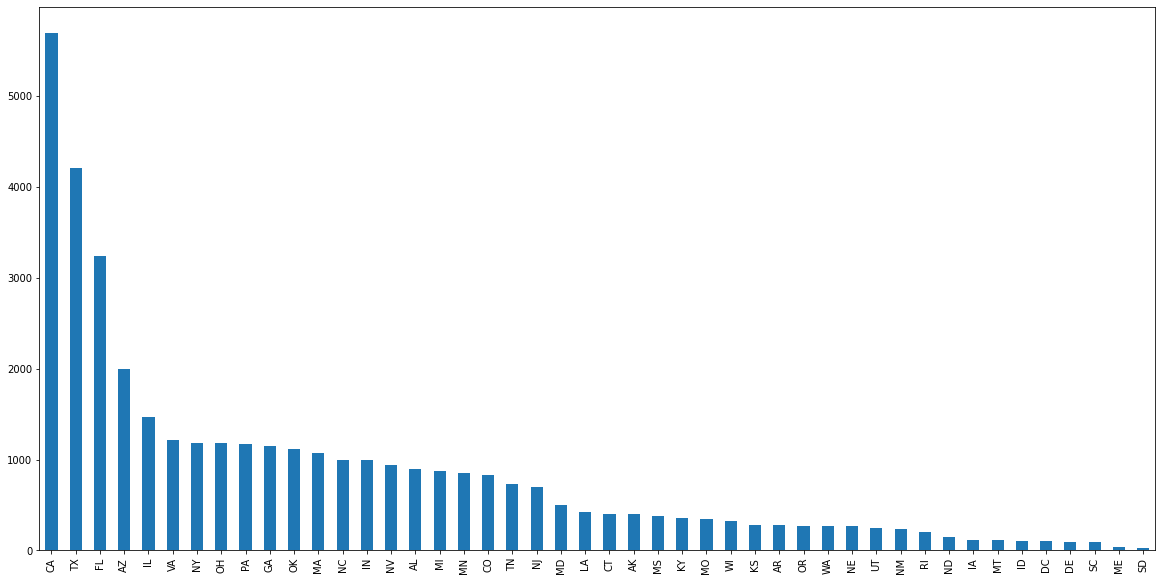

In [51]:
# Countplot by state, how many data we have for each state
plt.figure(figsize=(20,10))
house_df['State'].value_counts().plot(kind='bar')

We have most data in California, Texas, and Florida. Partial indicator that these states have more real estate activities.

[(0.0, 12397.35)]

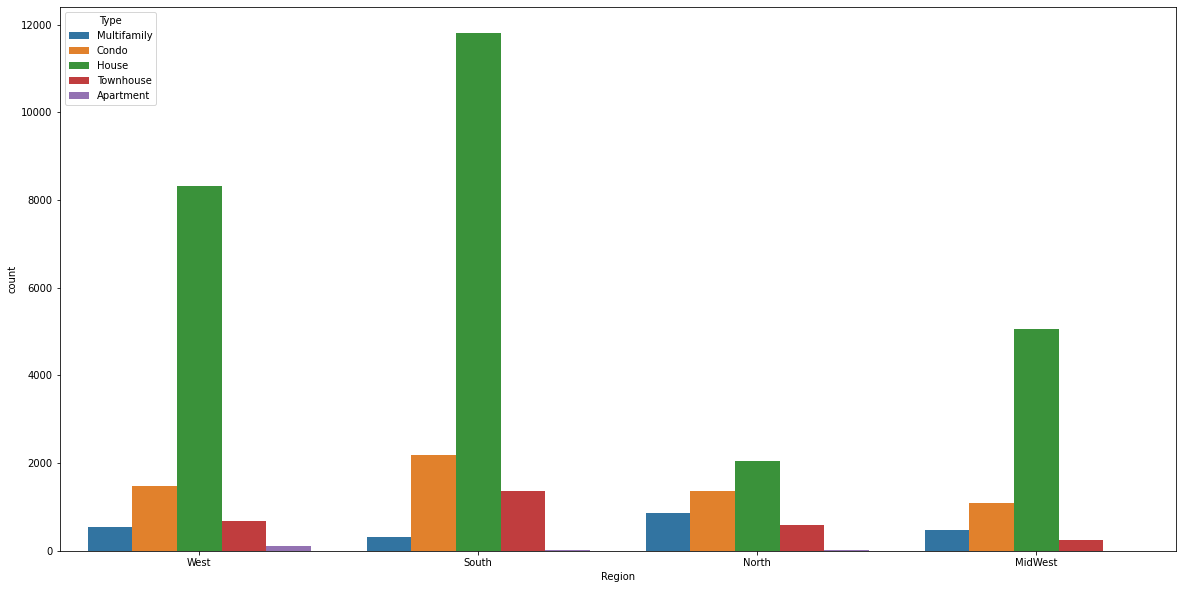

In [52]:
# Count plot x is region and hue is Type of houses
plt.figure(figsize=(20,10))
g=sns.countplot(x='Region',data=house_df,hue='Type')
g.set(ylim=(0, None))

Countplot by Region and hue of property types. <br>It is clear that Single Family Residence are primary market for United States<br> Condos are 2nd, follow by Townhouses as 3rd
<br>
The North Region has a high percentage of Condos relative to the houses. 

<AxesSubplot:xlabel='State', ylabel='Count'>

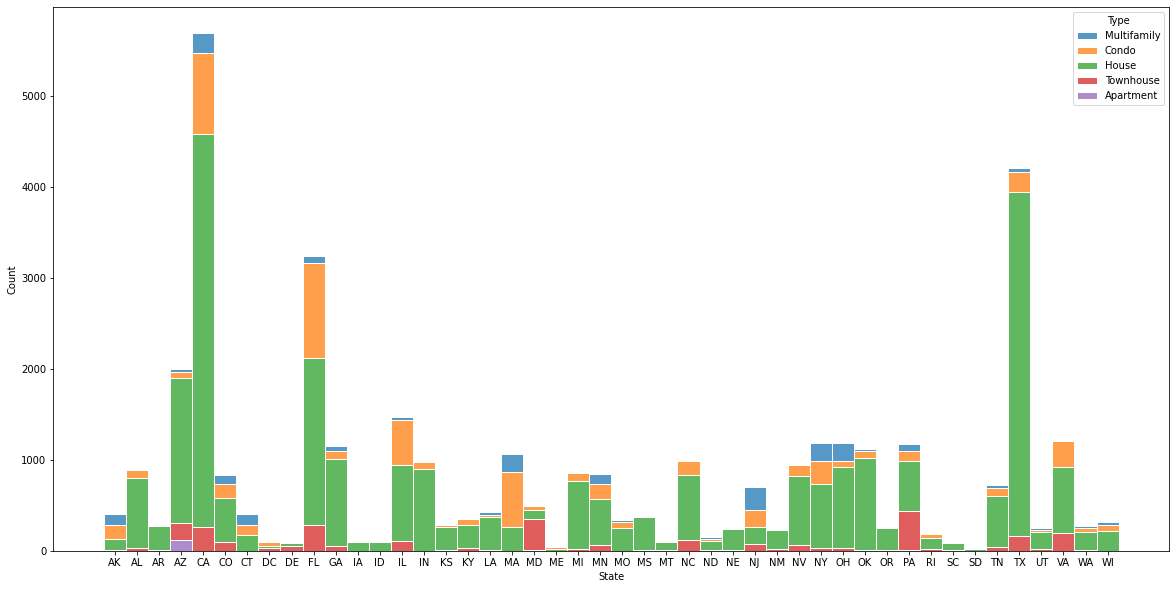

In [48]:
# Histplot stacked by type
plt.figure(figsize=(20,10))
sns.histplot(data=house_df,x='State',hue='Type',multiple='stack',edgecolor='white')

MA, AK, DC are primarily Condos.<br>
MD, PA, DE are primarily Townhouses.

<AxesSubplot:xlabel='perSqFt', ylabel='Size'>

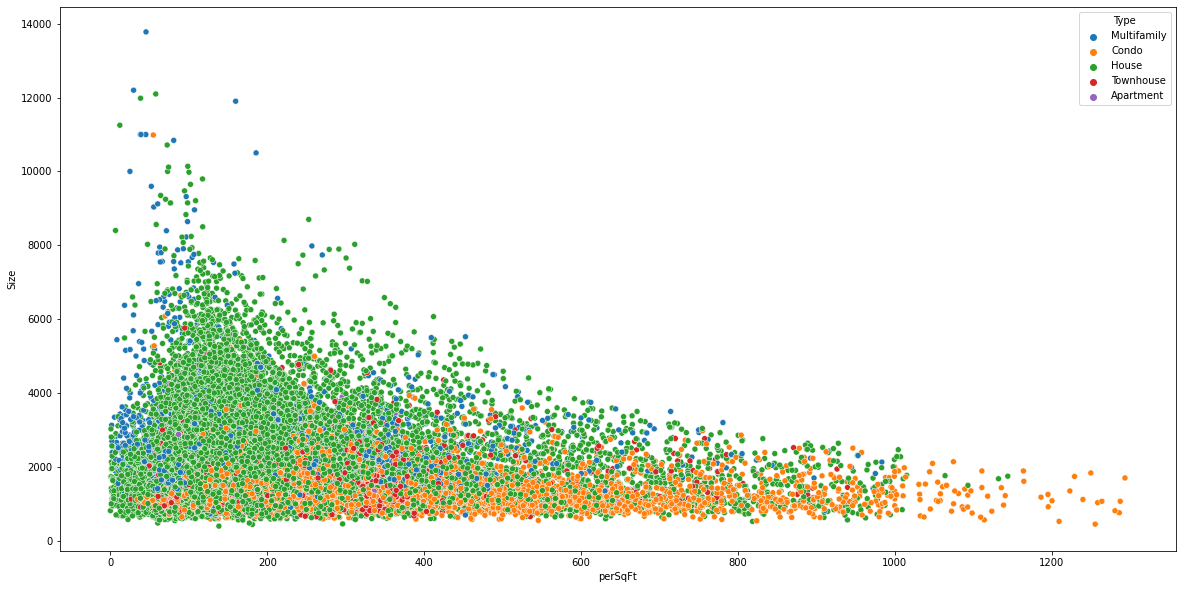

In [49]:
# Scatterplot perSqFt, Size, hue by Type
plt.figure(figsize=(20,10))
sns.scatterplot(data=house_df[house_df.Size < 15000],x='perSqFt',y='Size',hue='Type')


There is a clear indicator that the higher the perSqFt the smaller the house Size. <br> Most Condos have higher perSqFt prices.

<AxesSubplot:xlabel='Price', ylabel='Size'>

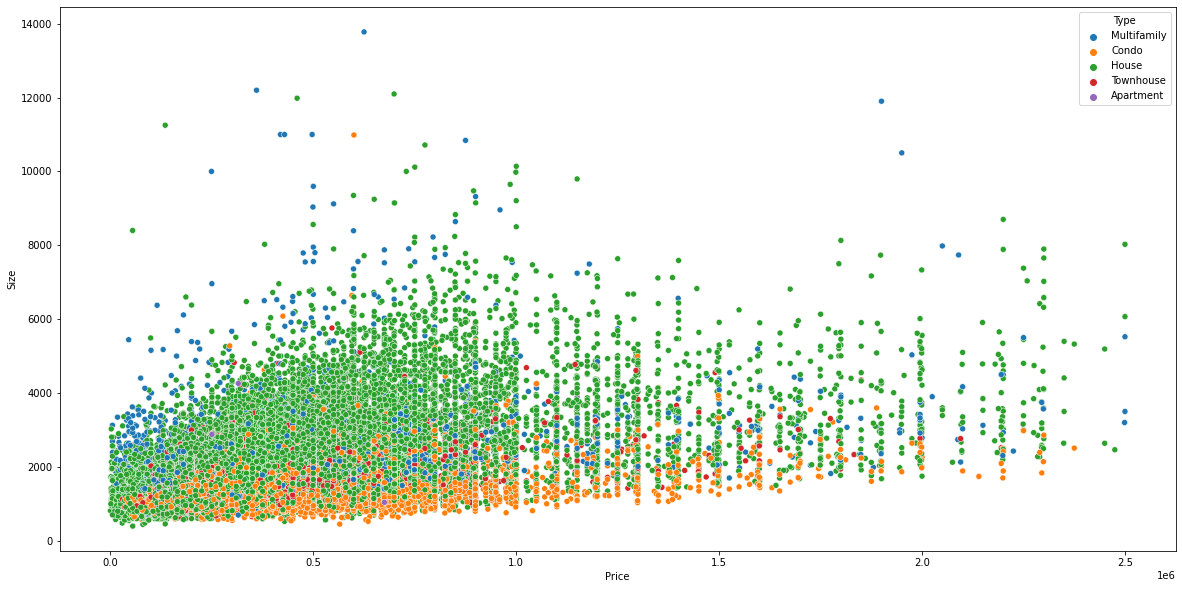

In [76]:
# Scatterplot perSqFt, Size, hue by Type
plt.figure(figsize=(20,10))
sns.scatterplot(data=house_df[house_df.Size < 15000],x='Price',y='Size',hue='Type')

Slight correlation between Price and Size. The larger the house the price will be slightly increased.

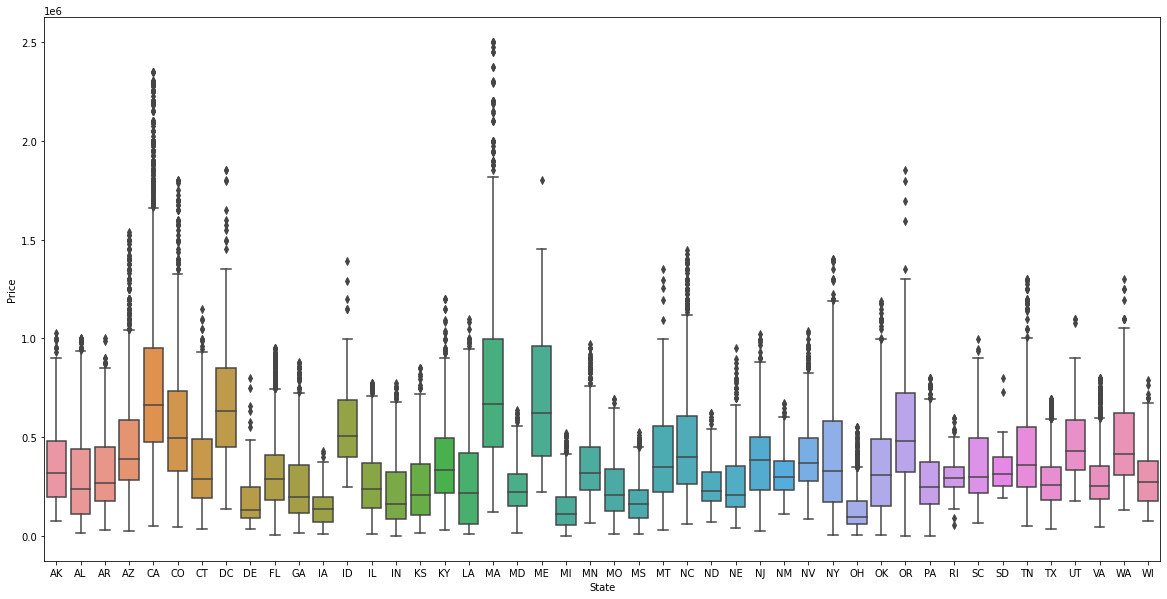

In [53]:
# Boxplot of States by House price
plt.figure(figsize=(20,10))
ax = sns.boxplot(data = house_df, x = 'State' , y = 'Price')

(0.0, 1358.2058209278798)

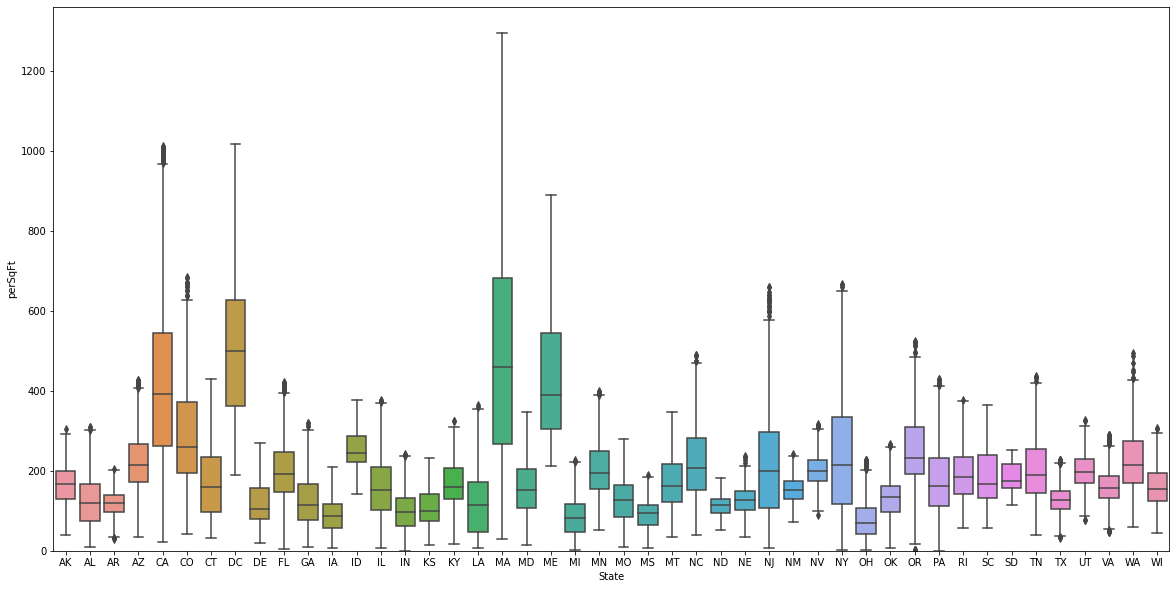

In [54]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data = house_df, x = 'State' , y = 'perSqFt')
ax.set_ylim(0,None)

#### State_df

##### Descriptive for State_df

In [55]:
state_df.describe()

,GDP,Spending,Population,Income,Bathrooms,Bedrooms,Price,Size,perSqFt,HouseCount,SavingsRate
count,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00,46.00
mean,390208.88,299606.37,7078103.24,419131.06,2.42,3.37,371201.70,2067.32,191.37,837.72,0.27
std,482294.66,340567.83,7600879.42,496796.28,0.29,0.35,160617.76,364.36,99.21,1081.61,0.04
min,46158.10,33631.30,714153.00,46430.30,1.81,2.78,134805.94,1525.06,79.73,25.00,0.16
25%,118834.20,98120.93,2929519.75,129528.12,2.23,3.16,270628.96,1816.06,124.58,255.50,0.23
50%,229092.70,187682.30,5106011.50,265093.00,2.46,3.33,345951.25,2040.44,167.14,415.50,0.27
75%,492387.12,365095.10,8402224.00,531894.30,2.61,3.45,425050.39,2287.30,217.56,1051.25,0.30
max,2663665.90,1835980.60,39613493.00,2763312.00,2.97,4.59,800687.64,3455.86,501.03,5696.00,0.36


In [82]:
# Finding Highest/Lowest 3 States of per square footage and size
sqft_top = state_df.sort_values(by='perSqFt',ascending=False).head(3)[['State','perSqFt']]
sqft_bot = state_df.sort_values(by='perSqFt',ascending=True).head(3)[['State','perSqFt']]
size_top = state_df.sort_values(by='Size',ascending=False).head(3)[['State','Size']]
size_bot = state_df.sort_values(by='Size',ascending=True).head(3)[['State','Size']]
# For loop to print the output for $ perSqFt
print('Top 3 Highest and Lowest $ perSqFt')
dflist = sqft_top, sqft_bot
for d in dflist:
    dict_d = dict(zip(d.iloc[:,0],d.iloc[:,1]))
    for k in dict_d:
        print('State {} have average of ${:.2f} per square feet'.format(k,dict_d[k]))

# For loop to print the output for Size
print('\nTop 3 Highest and Lowest House Size')
dflist2 = size_top, size_bot
for d in dflist2:
    dict_d = dict(zip(d.iloc[:,0],d.iloc[:,1]))
    for k in dict_d:
        print('State {} have average of {:.0f} square feet.'.format(k,dict_d[k]))

Top 3 Highest and Lowest $ perSqFt
State MA have average of $501.03 per square feet
State DC have average of $500.22 per square feet
State ME have average of $437.12 per square feet
State OH have average of $79.73 per square feet
State MI have average of $86.42 per square feet
State MS have average of $90.56 per square feet

Top 3 Highest and Lowest House Size
State NJ have average of 3456 square feet.
State AR have average of 2805 square feet.
State UT have average of 2524 square feet.
State DC have average of 1525 square feet.
State DE have average of 1538 square feet.
State MD have average of 1578 square feet.


In [57]:
# View the correlation in numbers.
state_df.corr()

,GDP,Spending,Population,Income,Bathrooms,Bedrooms,Price,Size,perSqFt,HouseCount,SavingsRate
GDP,1.00,0.99,0.98,0.99,-0.03,-0.04,0.21,-0.11,0.25,0.90,0.35
Spending,0.99,1.00,0.99,1.00,-0.05,-0.07,0.17,-0.13,0.22,0.92,0.29
Population,0.98,0.99,1.00,0.99,-0.04,-0.09,0.13,-0.13,0.16,0.93,0.25
Income,0.99,1.00,0.99,1.00,-0.05,-0.05,0.20,-0.12,0.24,0.91,0.33
Bathrooms,-0.03,-0.05,-0.04,-0.05,1.00,0.52,0.44,0.59,0.19,0.05,0.05
Bedrooms,-0.04,-0.07,-0.09,-0.05,0.52,1.00,0.10,0.70,-0.08,-0.09,0.29
Price,0.21,0.17,0.13,0.20,0.44,0.10,1.00,0.11,0.94,0.18,0.07
Size,-0.11,-0.13,-0.13,-0.12,0.59,0.70,0.11,1.00,-0.13,-0.12,0.18
perSqFt,0.25,0.22,0.16,0.24,0.19,-0.08,0.94,-0.13,1.00,0.19,0.08
HouseCount,0.90,0.92,0.93,0.91,0.05,-0.09,0.18,-0.12,0.19,1.00,0.19


##### Visualization for state_df

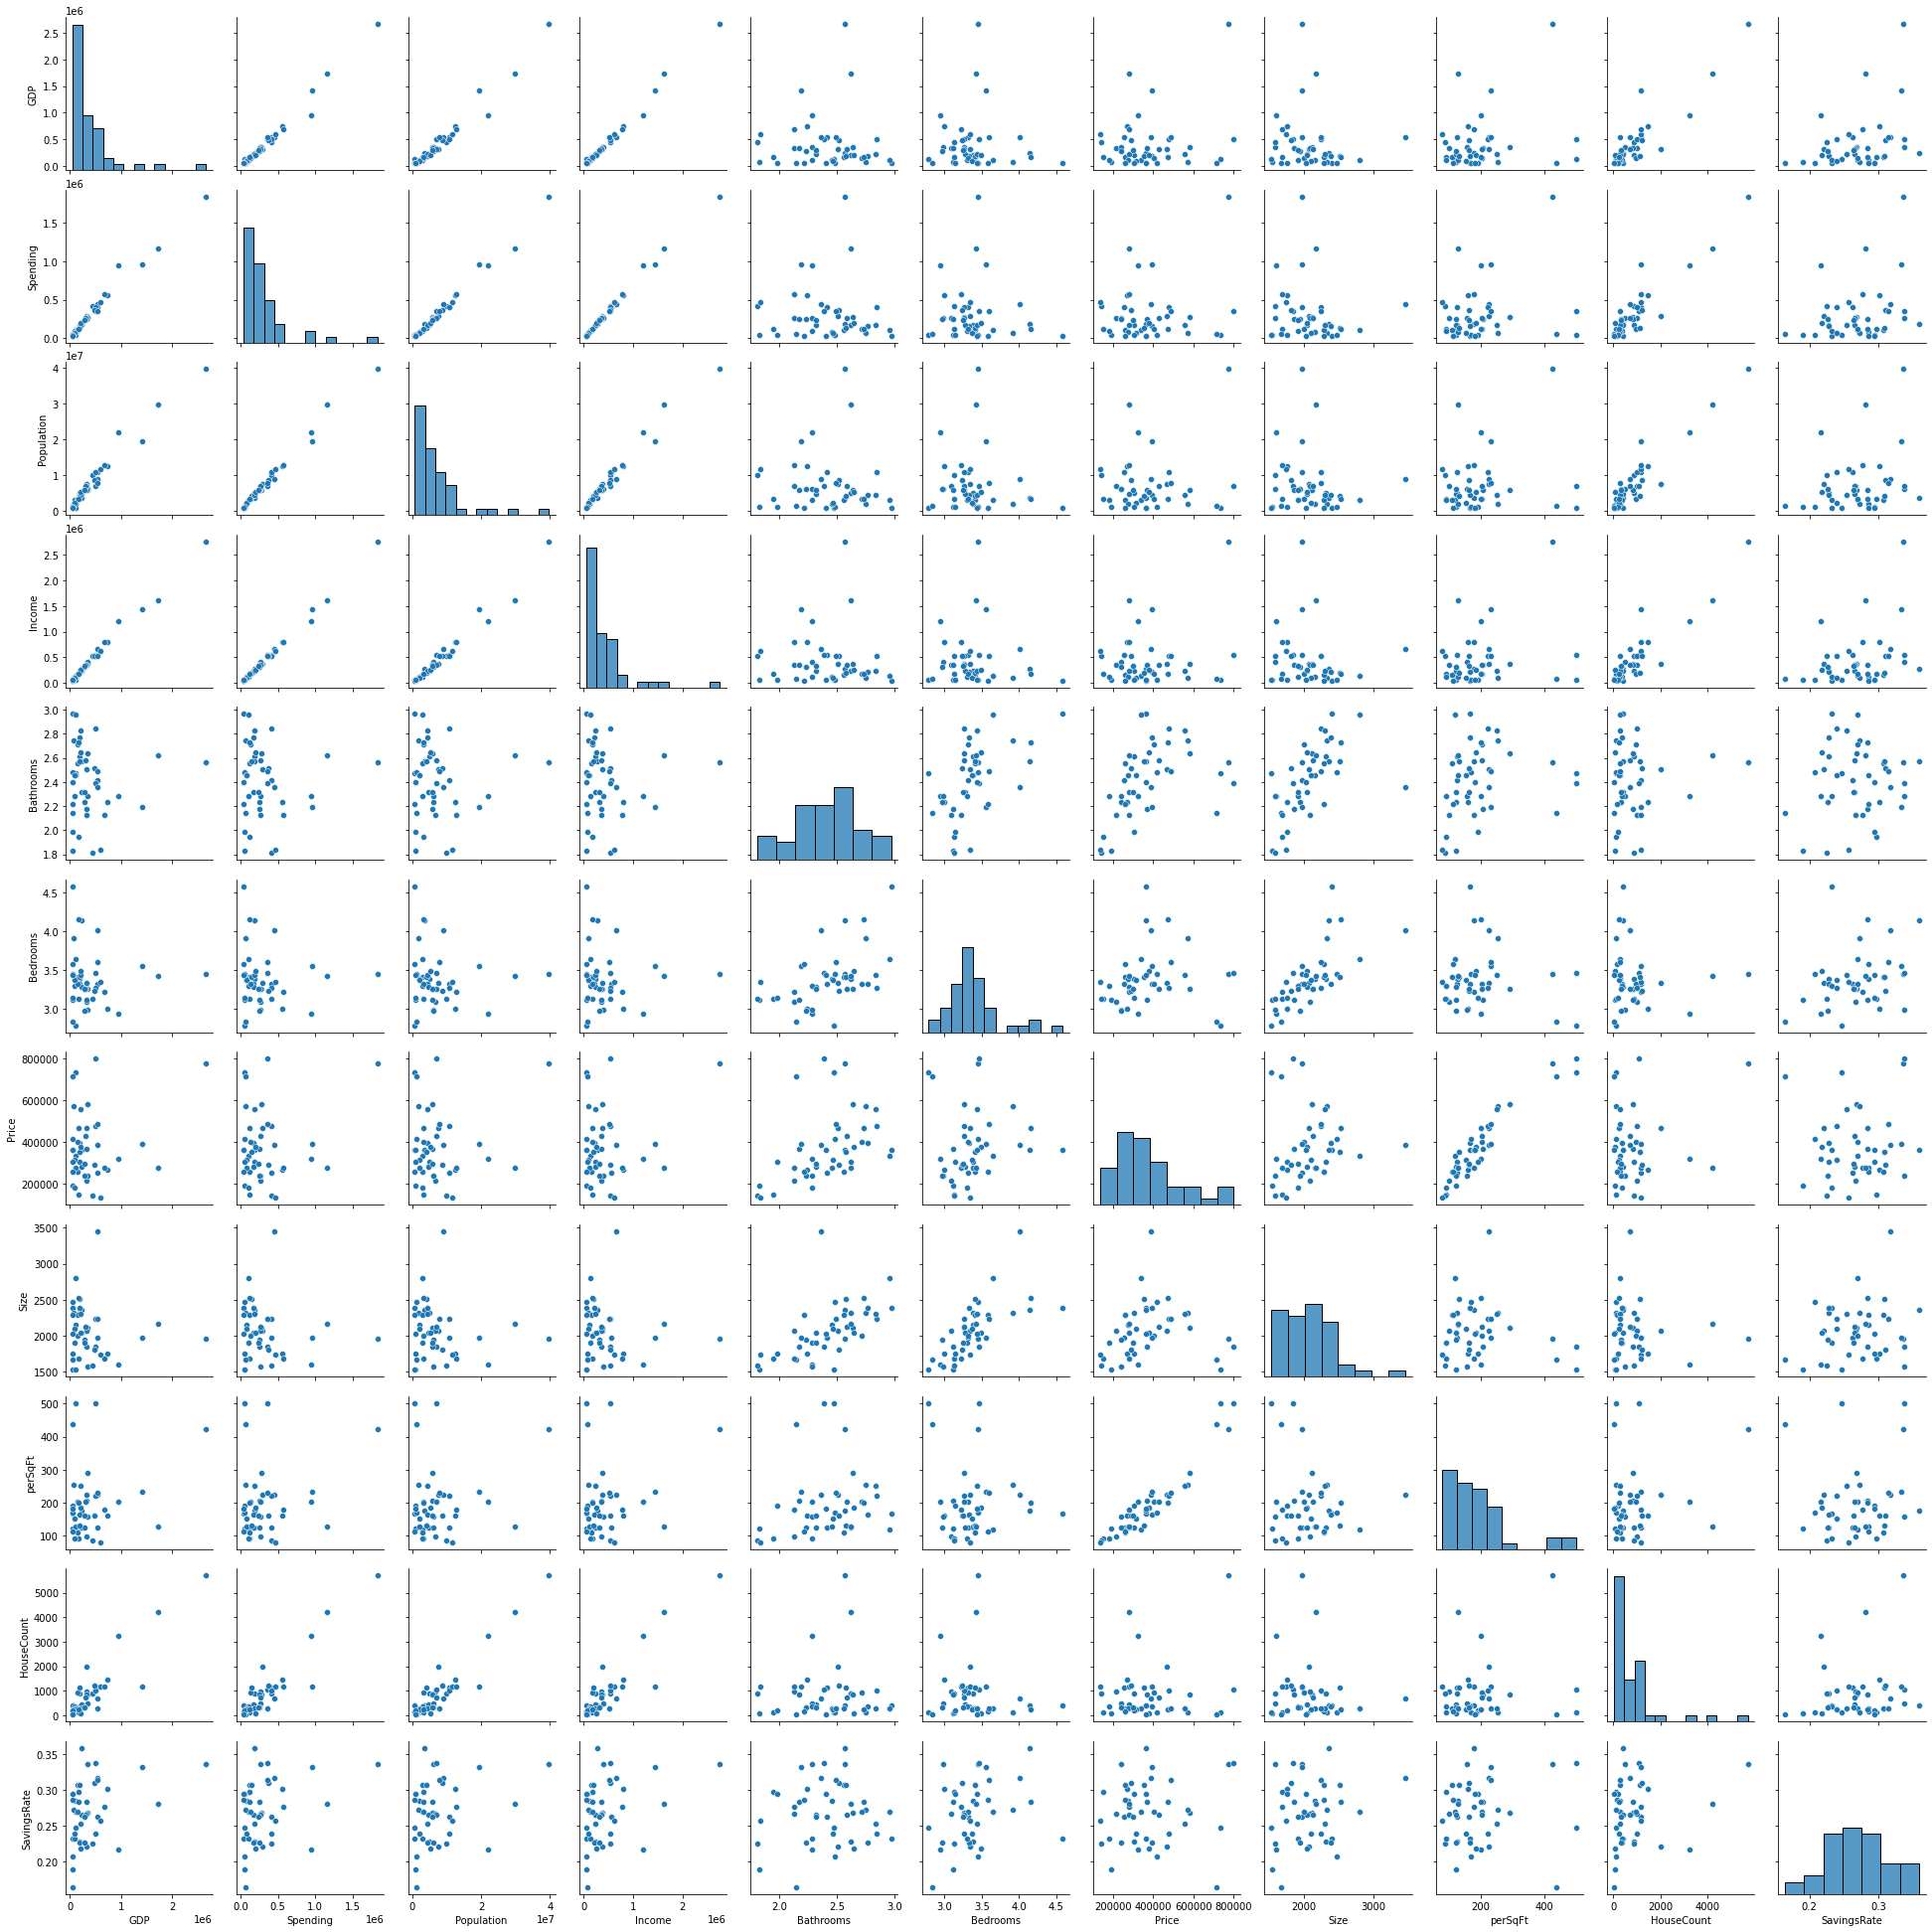

In [58]:
# Print pairplot to visualize the correlations. 
sns.pairplot(data=state_df)
# the more money you have the more bathrooms you will get.

GDP Income Spending and Population have a strong correlation. <br>
Additionally, number of houses sold also have a strong correlation with these. So more real estate activity with higher GDP Income Spending and Population
 <br>
SavingsRate and Bedrooms are slightly, the more you save the more bedrooms you are going to get.
<br>
Of course the bigger the house, the more Bedrooms and Bathrooms you will have.
<br>
SavingsRate and HouseCount has a slight correlation, the more you save, the more real estate activities there will be.

<AxesSubplot:xlabel='State', ylabel='Population'>

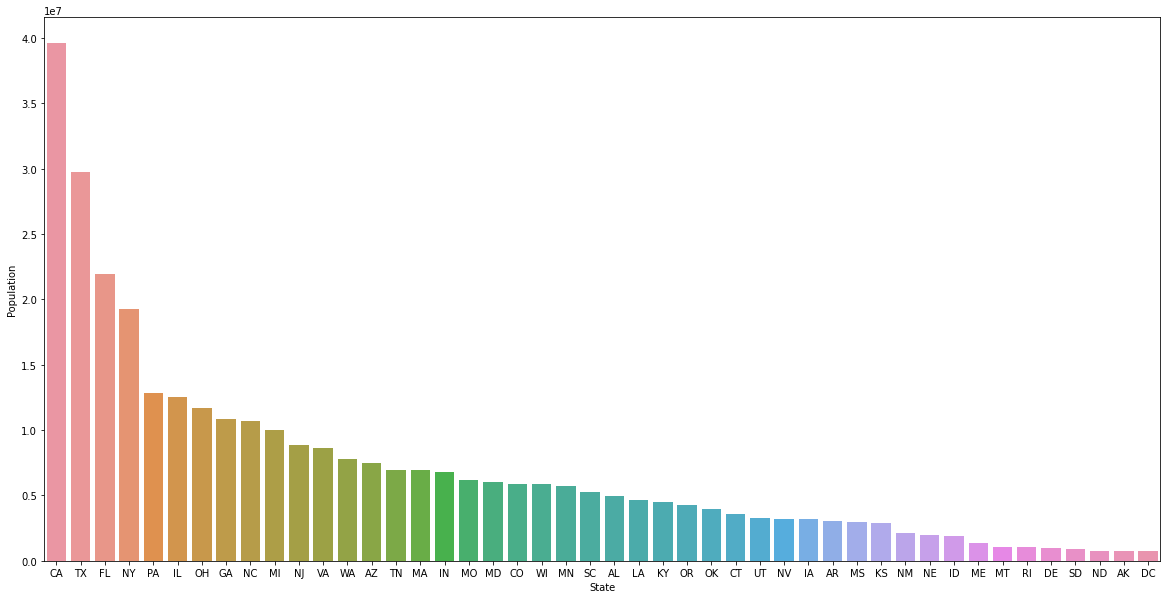

In [59]:
plt.figure(figsize=(20,10))
sorted_df = state_df.sort_values(by='Population',ascending=False)
sns.barplot(data=sorted_df, x='State',y='Population')

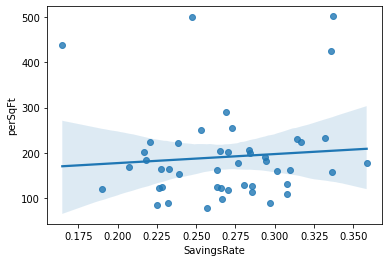

In [60]:
# Regression plot of SavingsRate vs perSqFt
g = sns.regplot(data = state_df, y = 'perSqFt', x = 'SavingsRate')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
# The States that have higher SavingRate will pay higher perSqFt for the houses. Note: perSqFt vs House price is two different things.

There is slight correlation between SavingsRate and perSqFt. <br>
As people saves more money, they pay higher perSqFt for the house.<br>
Note: This doesnt mean they will be better furnished houses, it may be geographic area. We dont have enough data/evidence to prove this.

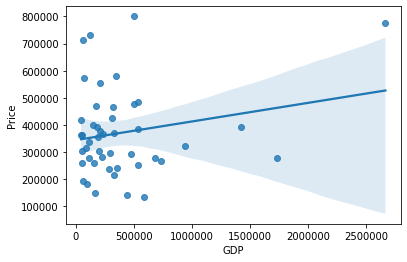

In [61]:
g = sns.regplot(data = state_df, x = 'GDP', y = 'Price')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
# g.set(xlim = (0,1000000))

<AxesSubplot:xlabel='State'>

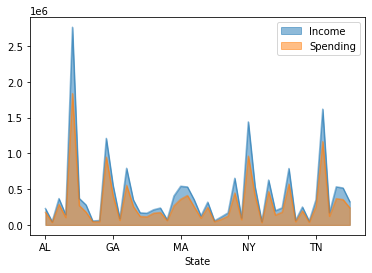

In [62]:
areaplot_df = state_df[['Income','Spending','State']]
areaplot_df.plot.area(x='State',stacked=False)

In [63]:



data = dict(type = 'choropleth',colorscale='Portland',locations=state_df['State'],locationmode='USA-states', z=state_df['Price'],text=state_df['Price'], colorbar={'title':'Price'})
choromap = go.Figure(data = [data],layout = dict(geo = {'scope':'usa'}))

iplot(choromap,validate=False)


In [64]:

data = dict(type = 'choropleth',colorscale='Portland',locations=state_df['State'],locationmode='USA-states', z=state_df['perSqFt'],text=state_df['perSqFt'], colorbar={'title':'perSqFt'})
choromap = go.Figure(data = [data],layout = dict(geo = {'scope':'usa'}))

iplot(choromap,validate=False)


In [65]:

data = dict(type = 'choropleth',colorscale='Portland',locations=state_df['State'],locationmode='USA-states', z=state_df['SavingsRate'],text=state_df['SavingsRate'], colorbar={'title':'SavingsRate'})
choromap = go.Figure(data = [data],layout = dict(geo = {'scope':'usa'}))

iplot(choromap,validate=False)


/var/folders/fy/_jcf8bdn3hbccf_yk638qvkw0000gn/T/ipykernel_88974/4129755072.py:4: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



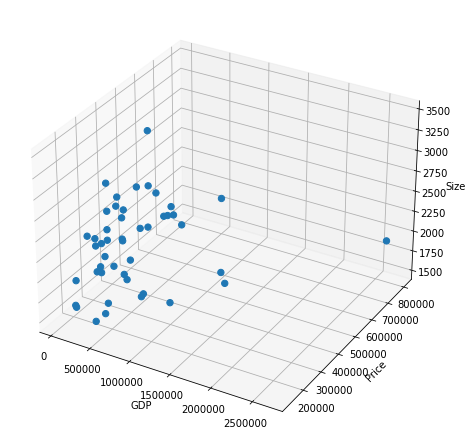

In [66]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)
ax.scatter(xs = state_df['GDP'], ys = state_df['Price'], zs = state_df['Size'], s=40, marker='o', alpha=1)
ax.set_xlabel('GDP')
ax.set_ylabel('Price')
ax.set_zlabel('Size')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

### Conclusion

In [67]:
'''



'''

'\n\n\n\n'

### References

In [68]:
'''
References

Data of:    Housing Price Data
https://www.kaggle.com/dataranch/zillow-1

Data of:    Population
https://worldpopulationreview.com/states

Data of:    GDP, Income, Spending 
https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&isuri=1&acrdn=1#reqid=70&step=1&isuri=1&acrdn=1


'''

'\nReferences\n\nData of:    Housing Price Data\nhttps://www.kaggle.com/dataranch/zillow-1\n\nData of:    Population\nhttps://worldpopulationreview.com/states\n\nData of:    GDP, Income, Spending \nhttps://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&isuri=1&acrdn=1#reqid=70&step=1&isuri=1&acrdn=1\n\n\n'